In [1]:
import pandas as pd 
import numpy as np
import scipy.stats
import pylab 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.tsa.stattools as sts 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from pmdarima.arima import auto_arima
import seaborn as sns

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

### Import Digester 15 data

In [2]:
data15 = pd.read_csv("linearmoddataset.csv")
data15.head()

,Time,Delta,Damkohler,Sigma,CUM_Steam,Woodloading
0,0,-0.260848,0.123912,0.937022,25.2,108.666275
1,1,-0.344876,0.116629,1.033851,26.9,109.853065
2,2,-0.339656,0.115659,1.027957,27.9,112.921150
3,3,-0.317045,0.126365,0.993998,28.6,112.257874
4,4,-0.284570,0.122794,0.971008,25.3,112.399788


<Axes: >

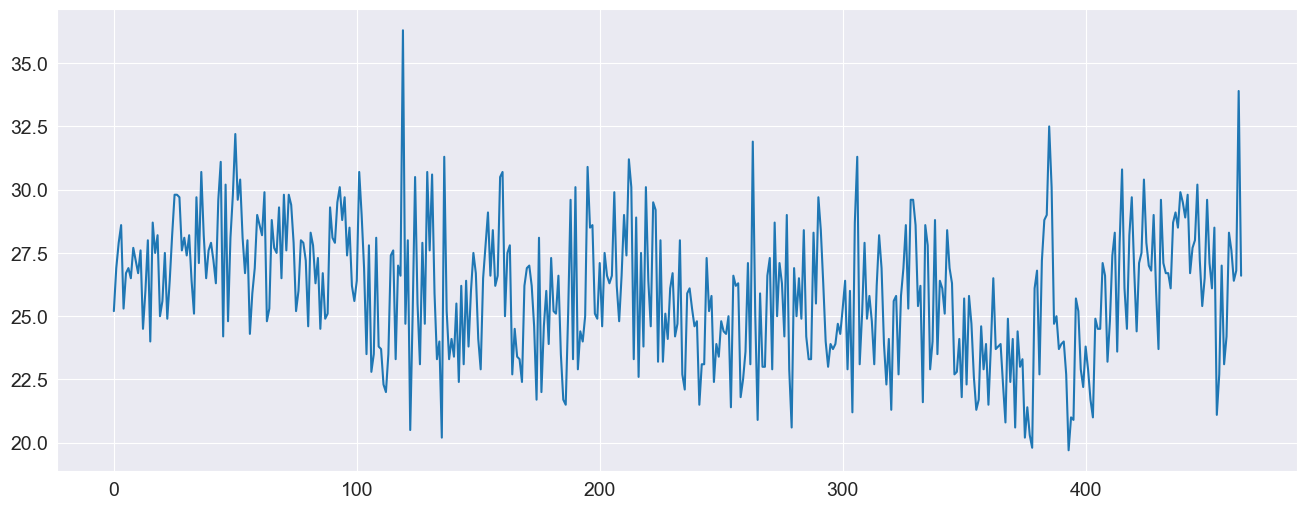

In [3]:
data15.CUM_Steam.plot()

## QQ Plot

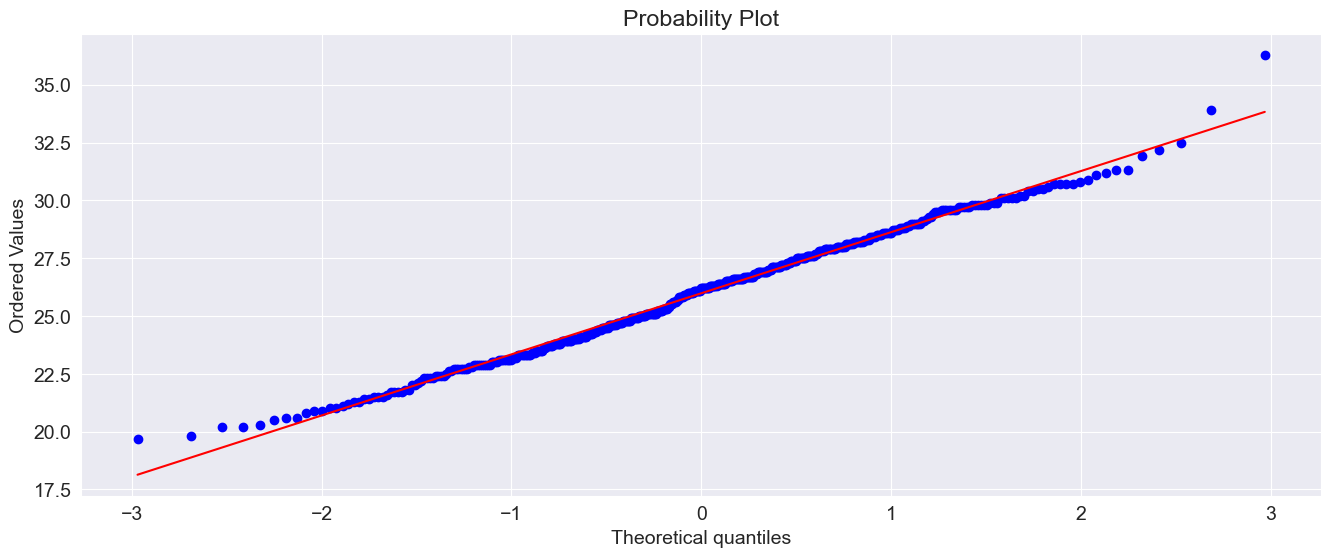

In [4]:
scipy.stats.probplot(data15.CUM_Steam, plot=pylab)
pylab.show()

In [5]:
data15.Time.describe()

count    465.000000
mean     232.000000
std      134.378198
min        0.000000
25%      116.000000
50%      232.000000
75%      348.000000
max      464.000000
Name: Time, dtype: float64

In [6]:
# Create a range of integers representing the time axis from 0 to 500
time_axis = range(0, len(data15))  # Assuming inclusive range from 0 to 500

# Multiply each integer by 60 to convert it to minutes
minutes = [t * 60 for t in time_axis]

# Convert the minutes to datetime format with 1-minute frequency
time_index = pd.date_range(start='2023-01-01', periods=len(minutes), freq='T')

# Assign the datetime index to the DataFrame
data15.index = time_index

# Drop the existing 'time' column
data15.drop(columns=['Time'], inplace=True)

# Rename the index to 'time'
data15.index.name = 'Time'

# Drop the existing 'Time' column if needed
data15_comp = data15.copy()

In [7]:
data15.head()

,Delta,Damkohler,Sigma,CUM_Steam,Woodloading
Time,,,,,
2023-01-01 00:00:00,-0.260848,0.123912,0.937022,25.2,108.666275
2023-01-01 00:01:00,-0.344876,0.116629,1.033851,26.9,109.853065
2023-01-01 00:02:00,-0.339656,0.115659,1.027957,27.9,112.921150
2023-01-01 00:03:00,-0.317045,0.126365,0.993998,28.6,112.257874
2023-01-01 00:04:00,-0.284570,0.122794,0.971008,25.3,112.399788


In [8]:
train_size = int(len(data15_comp)*0.8)

data15_train = data15_comp[:train_size]
data15_test = data15_comp[train_size:]

In [9]:
data15_train.tail()

,Delta,Damkohler,Sigma,CUM_Steam,Woodloading
Time,,,,,
2023-01-01 06:07:00,-0.073835,0.228220,0.688857,20.8,93.685860
2023-01-01 06:08:00,-0.233377,0.144645,0.845320,24.9,96.817580
2023-01-01 06:09:00,-0.211237,0.142652,0.822799,22.4,97.551506
2023-01-01 06:10:00,-0.238641,0.130567,0.879021,24.1,119.087486
2023-01-01 06:11:00,-0.163482,0.147009,0.771365,20.6,99.523340


In [10]:
data15_test.head

<bound method NDFrame.head of                         Delta  Damkohler     Sigma  CUM_Steam  Woodloading
Time                                                                      
2023-01-01 06:12:00 -0.043615   0.134034  0.769499       24.4   101.503891
2023-01-01 06:13:00 -0.184182   0.148725  0.784049       23.0   103.941475
2023-01-01 06:14:00 -0.171050   0.101626  0.829997       23.3   101.911926
2023-01-01 06:15:00 -0.076865   0.236652  0.679180       20.2    99.186844
2023-01-01 06:16:00 -0.144005   0.165673  0.740203       21.4    99.131840
...                       ...        ...       ...        ...          ...
2023-01-01 07:40:00 -0.323848   0.114924  1.015658       27.6   109.463623
2023-01-01 07:41:00 -0.241509   0.133081  0.880645       26.4   110.075432
2023-01-01 07:42:00 -0.400033   0.138290  1.058519       26.8   105.406654
2023-01-01 07:43:00 -0.592482   0.119804  1.284439       33.9   112.074486
2023-01-01 07:44:00 -0.321925   0.045041  1.136003       26.6   108.86

### Stationarity

In [11]:
sts.adfuller(data15_comp.CUM_Steam)

(-4.759509380404178,
 6.49627020900863e-05,
 6,
 458,
 {'1%': -3.4447087976702284,
  '5%': -2.867871300049488,
  '10%': -2.5701423432047443},
 2070.6125251471035)

### ACF

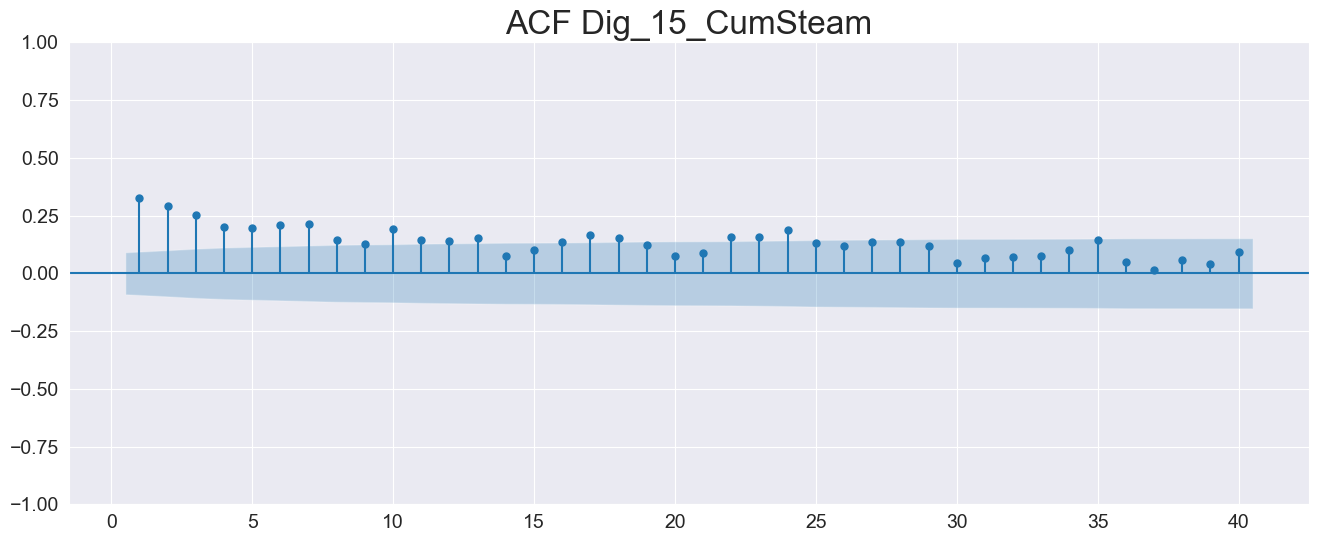

In [12]:
sgt.plot_acf(data15.CUM_Steam, lags = 40, zero = False)
plt.title("ACF Dig_15_CumSteam", size = 24)
plt.show()

### PACF

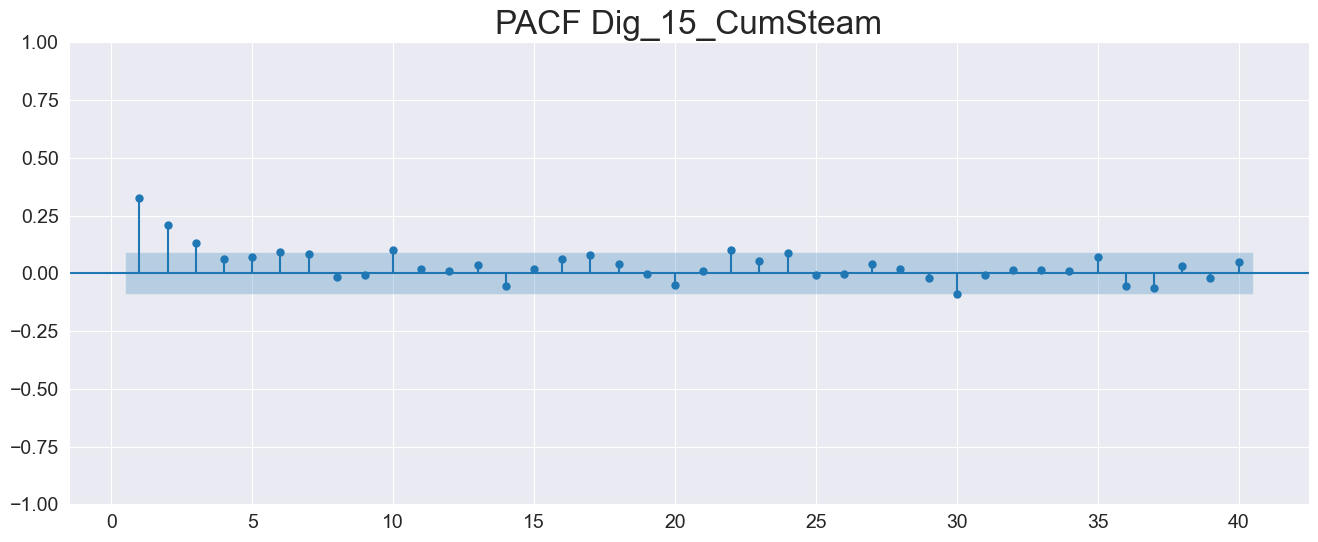

In [13]:
sgt.plot_pacf(data15.CUM_Steam, lags = 40, zero = False, method = ('ols'))
plt.title("PACF Dig_15_CumSteam", size = 24)
plt.show()

In [14]:
#LLR Test
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)

    return p

### AR Models

In [15]:
#AR1
model_ar1 = ARIMA(data15_train.CUM_Steam, order=(1, 0, 0))
results_ar1 = model_ar1.fit()
print(results_ar1.summary())

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -865.113
Date:                Fri, 08 Mar 2024   AIC                           1736.227
Time:                        13:26:59   BIC                           1747.983
Sample:                    01-01-2023   HQIC                          1740.896
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.9756      0.172    151.202      0.000      25.639      26.312
ar.L1          0.2427      0.049      4.922      0.000       0.146       0.339
sigma2         6.1294      0.459     13.342      0.0

In [16]:
#AR2
model_ar2 = ARIMA(data15_train.CUM_Steam, order=(2, 0, 0))
results_ar2 = model_ar2.fit()
print(results_ar2.summary())
print("LLR test: " + str(LLR_test(model_ar1, model_ar2)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -855.966
Date:                Fri, 08 Mar 2024   AIC                           1719.932
Time:                        13:27:00   BIC                           1735.608
Sample:                    01-01-2023   HQIC                          1726.158
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.9685      0.215    120.602      0.000      25.546      26.391
ar.L1          0.1899      0.049      3.849      0.000       0.093       0.287
ar.L2          0.2199      0.049      4.495      0.0

In [17]:
#AR3
model_ar3 = ARIMA(data15_train.CUM_Steam, order=(3, 0, 0))
results_ar3 = model_ar3.fit()
print(results_ar3.summary())
print("LLR test: " + str(LLR_test(model_ar2, model_ar3)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -854.487
Date:                Fri, 08 Mar 2024   AIC                           1718.974
Time:                        13:27:02   BIC                           1738.569
Sample:                    01-01-2023   HQIC                          1726.756
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.9646      0.236    110.014      0.000      25.502      26.427
ar.L1          0.1706      0.051      3.345      0.001       0.071       0.271
ar.L2          0.2033      0.049      4.139      0.0

In [18]:
#ARMA
model_arma11 = ARIMA(data15_train.CUM_Steam, order=(1, 0, 1))
results_arma = model_arma11.fit()
print(results_arma.summary())

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -847.213
Date:                Fri, 08 Mar 2024   AIC                           1702.426
Time:                        13:27:03   BIC                           1718.102
Sample:                    01-01-2023   HQIC                          1708.651
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.8291      0.627     41.217      0.000      24.601      27.057
ar.L1          0.9750      0.021     45.545      0.000       0.933       1.017
ma.L1         -0.8743      0.041    -21.325      0.0

In [19]:
#ARMA
model_arma12 = ARIMA(data15_train.CUM_Steam, order=(1, 0, 2))
results_arma = model_arma12.fit()
print(results_arma.summary())
print("LLR test: " + str(LLR_test(model_arma11, model_arma12)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -847.110
Date:                Fri, 08 Mar 2024   AIC                           1704.220
Time:                        13:27:04   BIC                           1723.815
Sample:                    01-01-2023   HQIC                          1712.002
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.8179      0.661     39.061      0.000      24.522      27.113
ar.L1          0.9778      0.021     47.479      0.000       0.937       1.018
ma.L1         -0.8595      0.057    -15.207      0.0

In [20]:
#************************** ARIMA 111 IS THE CORRECT MODEL ******************************#

#ARIMA111

model_arima111 = ARIMA(data15_train.CUM_Steam, order=(1, 1, 1))
results_arima111 = model_arima111.fit()
print(results_arima111.summary())
print("LLR test: " + str(LLR_test(model_arima111, model_arma11)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -846.484
Date:                Fri, 08 Mar 2024   AIC                           1698.967
Time:                        13:27:06   BIC                           1710.716
Sample:                    01-01-2023   HQIC                          1703.634
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0486      0.058      0.842      0.400      -0.065       0.162
ma.L1         -0.9202      0.024    -37.884      0.000      -0.968      -0.873
sigma2         5.5876      0.393     14.235      0.0

In [21]:
#ARIMA
model_arima121 = ARIMA(data15_train.CUM_Steam, order=(1, 2, 1))
results_arima121 = model_arima121.fit()
print(results_arima111.summary())
print("LLR test: " + str(LLR_test(model_arima111, model_arima121)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -846.484
Date:                Fri, 08 Mar 2024   AIC                           1698.967
Time:                        13:27:08   BIC                           1710.716
Sample:                    01-01-2023   HQIC                          1703.634
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0486      0.058      0.842      0.400      -0.065       0.162
ma.L1         -0.9202      0.024    -37.884      0.000      -0.968      -0.873
sigma2         5.5876      0.393     14.235      0.0

### ARIMA111 Training Plots

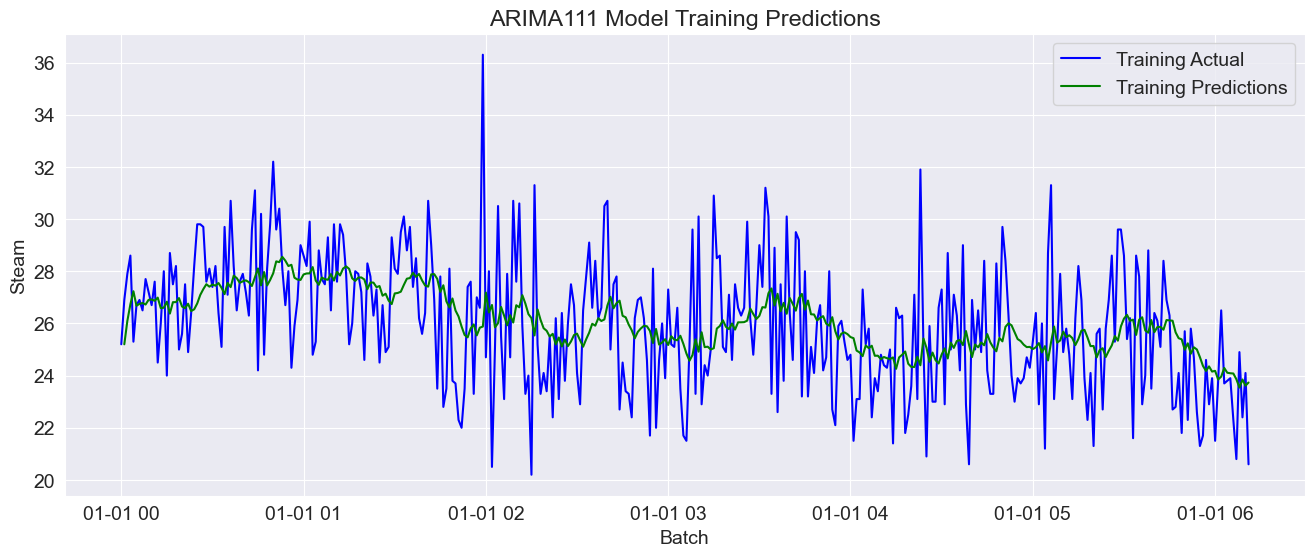

In [22]:
start_date = '2023-01-01 06:12:00'
end_date = '2023-01-01 07:44:00'

# Make predictions on training dataset
train_predictions = pd.DataFrame(results_arima111.predict())
#print(train_predictions)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Make predictions on test dataset
test_predictions = pd.DataFrame(results_arima111.predict(start=start_date, end=end_date))
#print(test_predictions)

# Plot actual values of training data
plt.plot(data15_train.index, data15_train['CUM_Steam'], color='blue', label='Training Actual')

# Plot predicted values of training data
plt.plot(data15_train.index[1:], train_predictions['predicted_mean'].iloc[1:], color='green', label='Training Predictions')

# Add labels and legend
plt.title('ARIMA111 Model Training Predictions')
plt.xlabel('Batch')
plt.ylabel('Steam')
plt.legend()

# Show plot
plt.show()

### ARIMA111 Training Performance

In [23]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_train['CUM_Steam'], train_predictions['predicted_mean'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_train['CUM_Steam'], train_predictions['predicted_mean']))
print('mae', mae)
print('rmse', rmse)

mae 1.9569423202429472
rmse 2.700013381547528


### ARIMA111 Test Plots

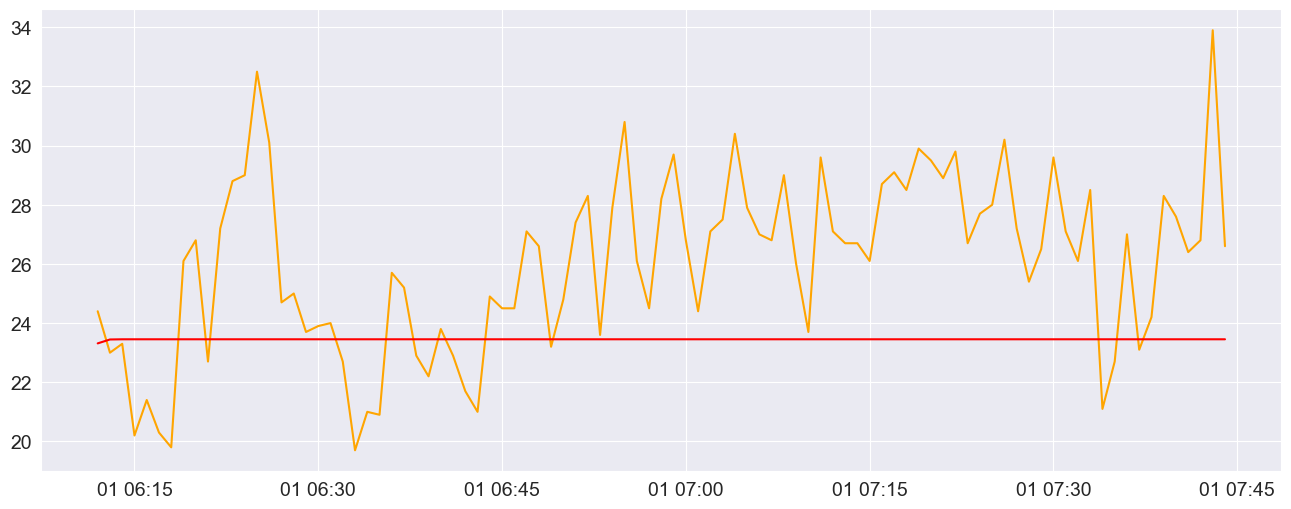

In [24]:
# Plot test data
plt.plot(data15_test.index, data15_test['CUM_Steam'], color='orange', label='Test')

# Plot forecasted values of test data
plt.plot(data15_test.index, test_predictions['predicted_mean'], color='red', label='Forecast')

# Show plot
plt.show()

### ARIMA111 Test Performance

In [25]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_test['CUM_Steam'], test_predictions['predicted_mean'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_test['CUM_Steam'], test_predictions['predicted_mean']))
print('mae', mae)
print('rmse', rmse)

mae 3.2488101448482087
rmse 3.8915725941465342


### ARIMAX With Woodload

In [26]:
# Define exogenous variables
exog_vars = data15_train[['Woodloading']]

# Fit AutoARIMA model with exogenous variables
model_arimax = ARIMA(data15_train['CUM_Steam'], exog=exog_vars, order=(1,1,1)) 
res_arimax = model_arimax.fit()
res_arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -845.463
Date:                Fri, 08 Mar 2024   AIC                           1698.926
Time:                        13:27:15   BIC                           1714.590
Sample:                    01-01-2023   HQIC                          1705.147
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Woodloading    -0.0237      0.017     -1.391      0.164      -0.057       0.010
ar.L1           0.0363      0.058      0.620      0.535      -0.078       0.151
ma.L1          -0.9172      0.025    -37.086      0.000      -0.966      -0.869
sigma2          5.5569      0.388     14.316      0.000       4.796       6.318
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                14.03
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.39
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMAX111 with Woodload Training Plots

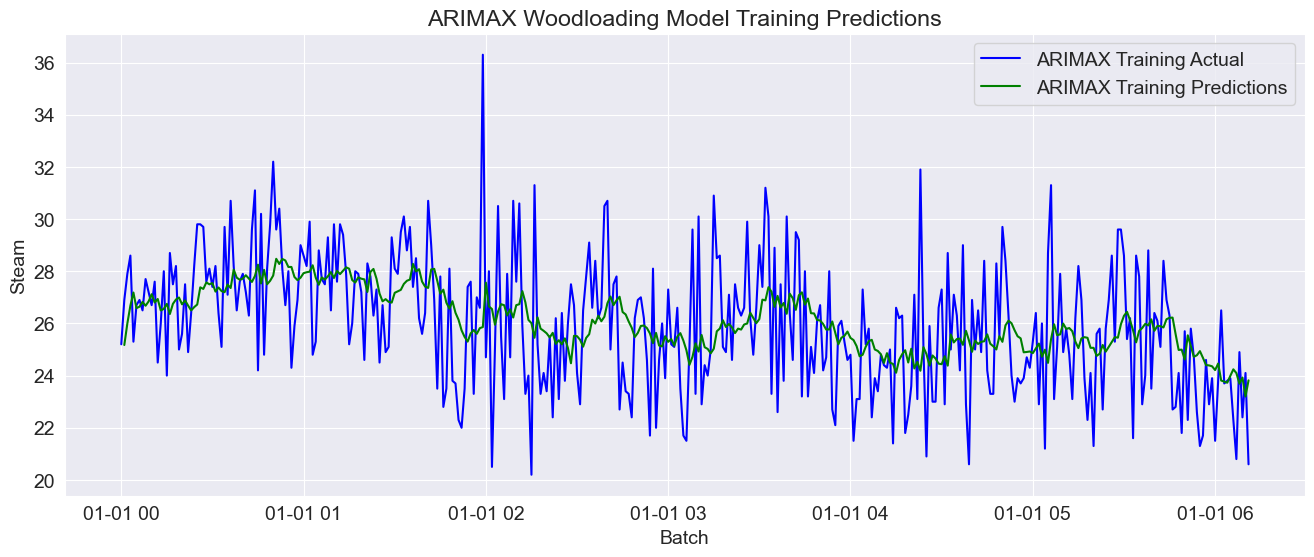

In [27]:
start_date = '2023-01-01 06:12:00'
end_date = '2023-01-01 07:44:00'
exog_vars_test = data15_test[['Woodloading']]

# Make predictions on training dataset
train_predictions = pd.DataFrame(res_arimax.predict())
#print(train_predictions)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Make predictions on test dataset
arimax_test_predictions = pd.DataFrame(res_arimax.predict(start=start_date, end=end_date, exog=exog_vars_test))
#print(test_predictions)

# Plot actual values of training data
plt.plot(data15_train.index, data15_train['CUM_Steam'], color='blue', label='ARIMAX Training Actual')

# Plot predicted values of training data
plt.plot(data15_train.index[1:], train_predictions['predicted_mean'].iloc[1:], color='green', label='ARIMAX Training Predictions')

# Add labels and legend
plt.title('ARIMAX Woodloading Model Training Predictions')
plt.xlabel('Batch')
plt.ylabel('Steam')
plt.legend()

# Show plot
plt.show()

### ARIMAX111 Woodload Training Performance

In [28]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_train['CUM_Steam'], train_predictions['predicted_mean'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_train['CUM_Steam'], train_predictions['predicted_mean']))
print('mae', mae)
print('rmse', rmse)

mae 1.9597868249575203
rmse 2.7616999867399494


### ARIMAX with Woodload test plots

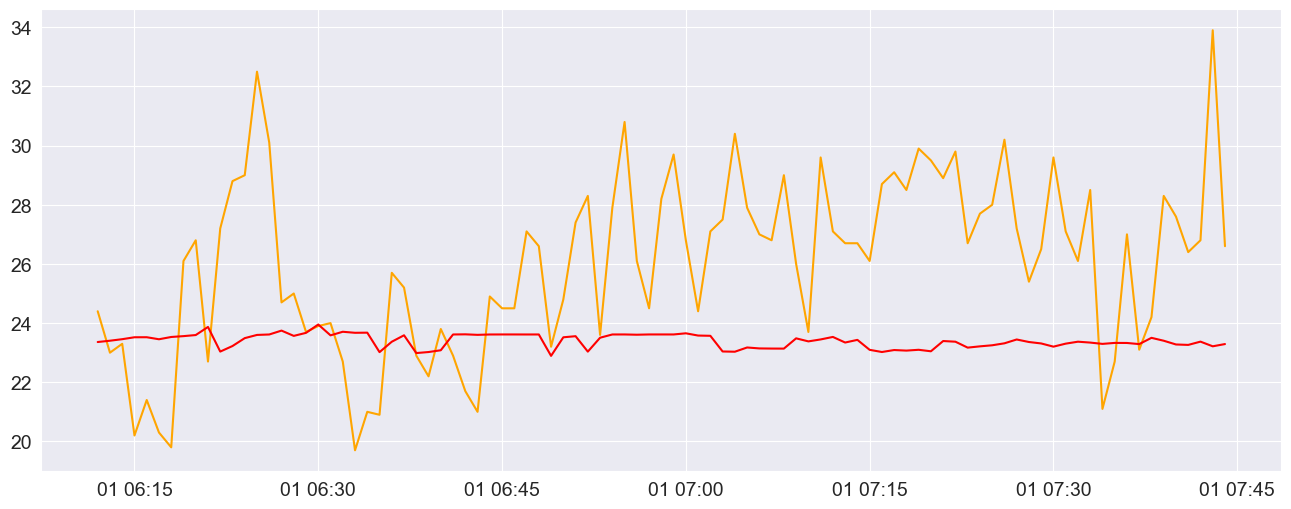

In [29]:
# Plot test data
plt.plot(data15_test.index, data15_test['CUM_Steam'], color='orange', label='Test')

# Plot forecasted values of test data
plt.plot(data15_test.index, arimax_test_predictions['predicted_mean'], color='red', label='Forecast')

# Show plot
plt.show()

### ARIMAX with Woodload test performance

In [30]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean']))

print('mae', mae)
print('rmse', rmse)

mae 3.296320308605844
rmse 3.9764452535230235


### ARIMAX with all Parameters

In [31]:
# Define exogenous variables
exog_vars = data15_train[['Delta', 'Damkohler', 'Sigma']]

# Fit AutoARIMA model with exogenous variables
model_arimax = ARIMA(data15_train['CUM_Steam'], exog=exog_vars, order=(1,1,1)) 
res_arimax = model_arimax.fit()
res_arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -704.275
Date:                Fri, 08 Mar 2024   AIC                           1420.549
Time:                        13:27:20   BIC                           1444.046
Sample:                    01-01-2023   HQIC                          1429.881
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Delta         -1.9717      1.146     -1.721      0.085      -4.217       0.274
Damkohler      7.1833      1.605      4.476      0.000       4.038      10.329
Sigma         14.7848      0.973     15.188      0.000      12.877      16.693
ar.L1          0.1398      0.057      2.443      0.015       0.028       0.252
ma.L1         -0.9636      0.014    -68.400      0.000      -0.991      -0.936
sigma2         2.5918      0.200     12.967      0.000       2.200       2.984
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.13
Prob(Q):                              0.84   Prob(JB):                         0.94
Heteroskedasticity (H):               0.82   Skew:                             0.03
Prob(H) (two-sided):                  0.26   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMAX111 with all parameters training plots

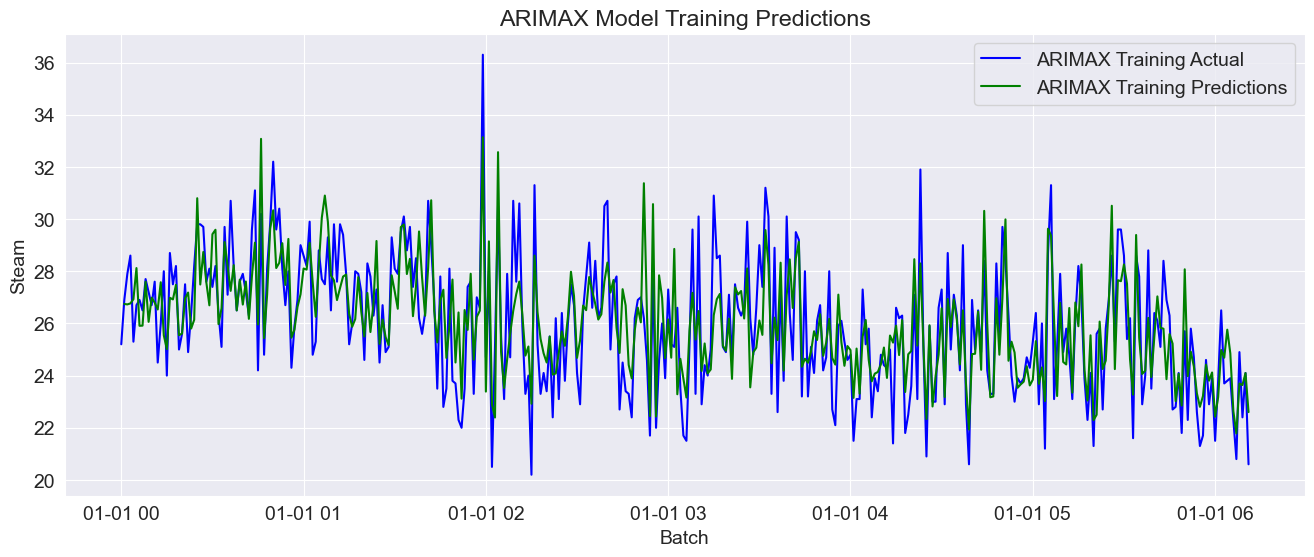

In [32]:
start_date = '2023-01-01 06:12:00'
end_date = '2023-01-01 07:44:00'
exog_vars_test = data15_test[['Delta', 'Damkohler', 'Sigma']]

# Make predictions on training dataset
train_predictions = pd.DataFrame(res_arimax.predict())
#print(train_predictions)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Make predictions on test dataset
arimax_test_predictions = pd.DataFrame(res_arimax.predict(start=start_date, end=end_date, exog=exog_vars_test))
#print(test_predictions)

# Plot actual values of training data
plt.plot(data15_train.index, data15_train['CUM_Steam'], color='blue', label='ARIMAX Training Actual')

# Plot predicted values of training data
plt.plot(data15_train.index[1:], train_predictions['predicted_mean'].iloc[1:], color='green', label='ARIMAX Training Predictions')

# Add labels and legend
plt.title('ARIMAX Model Training Predictions')
plt.xlabel('Batch')
plt.ylabel('Steam')
plt.legend()

# Show plot
plt.show()

### Training Performance

In [33]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_train['CUM_Steam'], train_predictions['predicted_mean'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_train['CUM_Steam'], train_predictions['predicted_mean']))

print('mae', mae)
print('rmse', rmse)

mae 1.3152550600659911
rmse 1.6908913798340917


### ARIMAX test plots

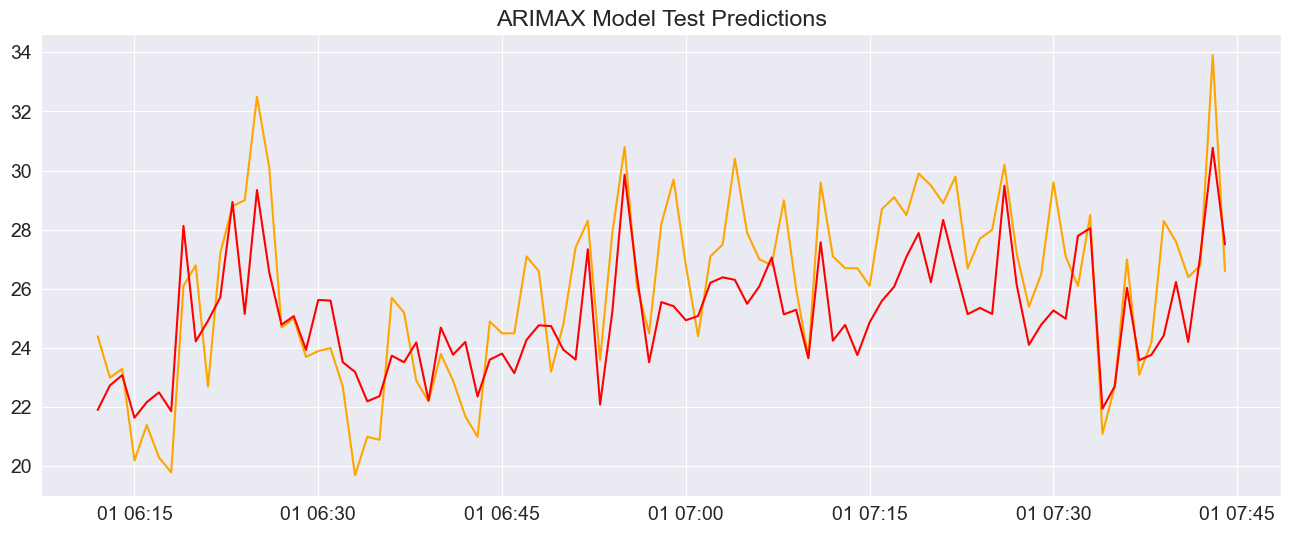

In [34]:
# Plot test data
plt.plot(data15_test.index, data15_test['CUM_Steam'], color='orange', label='Test')

# Plot forecasted values of test data
plt.plot(data15_test.index, arimax_test_predictions['predicted_mean'], color='red', label='Forecast')

# Add labels and legend
plt.title('ARIMAX Model Test Predictions')

# Show plot
plt.show()

### Test Performance

In [35]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean']))

print('mae', mae)
print('rmse', rmse)

mae 1.690760351606361
rmse 2.0295382829599884
